In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from typing import Literal
from keras import optimizers
from keras import losses

from src.models import CustomFFNN
from src.data_import import load_data

2024-11-12 20:48:18.442952: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 20:48:18.446307: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 20:48:18.457436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 20:48:18.476776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 20:48:18.482068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 20:48:18.497255: I tensorflow/core/platform/cpu_feature_gu

In [2]:
def get_C(F: tf.Tensor) -> tf.Tensor:
    return tf.transpose(F) @ F

def get_dataset(data: list[tuple[tf.Tensor, tf.Tensor, tf.Tensor]], which: Literal['P', 'W'] = 'P') -> tuple[tf.Tensor, tf.Tensor]:
    features = []
    labels = []

    for F, P, W in data:
        C = get_C(F)
        independent_C = tf.stack([
            C[0, 0], 
            C[1, 1],
            C[2, 2],
            C[0, 1],
            C[0, 2],
            C[1, 2],
        ])
        features.append(tf.reshape(independent_C, [-1]))
        labels.append(tf.reshape(P, [-1]))

    return tf.stack(features), tf.stack(labels)


In [3]:
data_path = os.path.abspath(os.path.join('calibration', 'biaxial.txt'))
data = load_data(data_path)
features, labels = get_dataset(data)

In [4]:
naive_model = CustomFFNN(
    input_size=6, 
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
h = naive_model.fit(features, labels, batch_size=16, validation_split=0.2, epochs=2000, verbose=1)
loss = h.history['loss']
val_loss = h.history['val_loss']

Epoch 1/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 399.5711 - val_loss: 1947.3090
Epoch 2/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 332.8084 - val_loss: 741.4417
Epoch 3/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 182.2936 - val_loss: 95.4922
Epoch 4/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84.4828 - val_loss: 110.6609
Epoch 5/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 39.3853 - val_loss: 13.9315
Epoch 6/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.8219 - val_loss: 28.1801
Epoch 7/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0960 - val_loss: 79.3204
Epoch 8/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2157 - val_loss: 41.2277
Epoch 9/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2937 - val_loss: 38.8775
Epoch 10/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0423 - val_loss: 71.3860
Epoch 11/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9566 - val_loss: 50.9242
Epoch 12/2000
10/10 ━━━━━━━

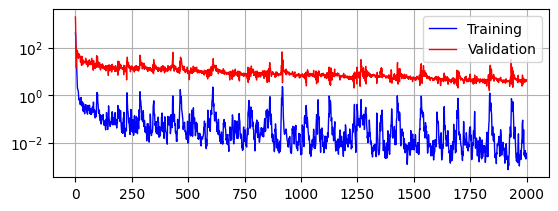

In [6]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(loss, color='blue', lw=1, label='Training')
line, = ax.plot(val_loss, color='red', lw=1, label='Validation')
ax.set_yscale('log')
plt.grid()
plt.legend()
plt.show()